In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.activations import tanh
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import seaborn as sns


# for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report


# for model plot
from tensorflow.keras.utils import plot_model

# others
from collections import defaultdict
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

Config

In [2]:
# As required in the assignment, we will use the following config:

test_data_dir = './data/images/val/'
train_data_dir = './data/images/train/'
validation_split = 0.18

Utilities

In [3]:
# Display image set

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

## DATA

In [4]:
## Check number of images in each class

image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
directories = [train_data_dir, test_data_dir]
directory_counts = {}

for directory in directories:
    subfolder_counts = {}

    for root, dirs, files in os.walk(directory):
        if root != directory:
            subfolder_name = os.path.relpath(root, directory)
            total_images = sum(1 for file in files if file.lower().endswith(tuple(image_extensions)))
            subfolder_counts[subfolder_name] = total_images

    directory_counts[directory] = subfolder_counts

# Print results
for directory, subfolder_counts in directory_counts.items():
    print(f"Directory: '{directory}'")
    for subfolder, count in subfolder_counts.items():
        print(f"  Subfolder '{subfolder}': {count} images")


Directory: './data/images/train/'
  Subfolder 'cat': 800 images
  Subfolder 'rabbit': 800 images
Directory: './data/images/val/'
  Subfolder 'cat': 207 images
  Subfolder 'rabbit': 207 images


In [5]:
## Check the sizes of the images

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size

# Function to count and group images by dimensions in subfolders
def count_and_group_images(directory):
    dimension_counts = defaultdict(int)

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_path = os.path.join(root, file)
                width, height = get_image_dimensions(image_path)
                dimension_counts[(width, height)] += 1

    for (width, height), count in dimension_counts.items():
        print(f"{count} images with size {width}x{height}")

# Count and group images by dimensions in the train directory
print("Train Directory:")
count_and_group_images(train_data_dir)

# Count and group images by dimensions in the validation directory
print("\nTest Directory:")
count_and_group_images(test_data_dir)

Train Directory:
1600 images with size 300x300

Test Directory:
414 images with size 300x300


In [6]:
# Load and preprocess images for EDA
cat_images = load_images_from_folder(os.path.join(train_data_dir, 'cat'))
rabbit_images = load_images_from_folder(os.path.join(train_data_dir, 'rabbit'))


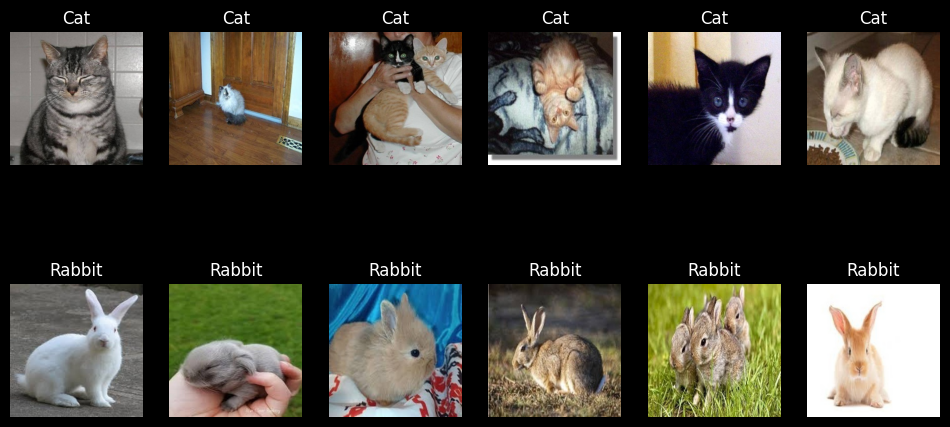

In [7]:
# Display 6 random images from each class as required

sample_cat_images = random.sample(cat_images, 6)
sample_rabbit_images = random.sample(rabbit_images, 6)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(sample_cat_images[i])
    plt.title('Cat')
    plt.axis('off')
    plt.subplot(2, 6, i + 7)
    plt.imshow(sample_rabbit_images[i])
    plt.title('Rabbit')
    plt.axis('off')
plt.show()

Data Quality is.... not ideal, and the quantity is seriously lacking, especially when the test folder is not used. Lets see what we can do

In [8]:
image_size = (300, 300)
image_height = 300
image_width = 300

datagen = ImageDataGenerator(rescale=1 / 255.0)

In [9]:
batch_size = 32
train_generator = datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=55
)
valid_generator = datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=55
)
test_generator = datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=image_size,
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=55
)

Found 1600 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


## MODEL

In [13]:
# Create a CNN model with tanh and maxpool
model = Sequential([
    tf.keras.layers.Rescaling(1.0 / 255, input_shape=(image_height, image_width, 3)),
    tf.keras.layers.Conv2D(10, (2, 2), strides=(2,2), padding='same', activation=tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(5, (2, 2), strides=(2,2), padding='same', activation=tanh),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation=tanh),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(25, activation=tanh),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 10)      130       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 10)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 75, 75, 10)        40        
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 5)         205       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 19, 19, 5)        

Train test split

In [15]:
# Train the model for at least 10 epochs
epc = 10 # required Epochs

callback = [tf.keras.callbacks.EarlyStopping(
                        monitor='loss',
                        patience=3,
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=epc,  # as required, minimum 50 epoches, earliest it will stop is 53 epoches (50 + 3)
                    )
            ]

history = model.fit_generator(
                train_generator, 
                epochs=30, 
                steps_per_epoch = train_generator.n//train_generator.batch_size,
                validation_steps = valid_generator.n//valid_generator.batch_size,
                callbacks=callback, 
                validation_data=valid_generator)

Epoch 1/30
50/50 [==============================] - 5s 101ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 2/30
47/50 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000

KeyboardInterrupt: 

Visualising Results

NameError: name 'history' is not defined

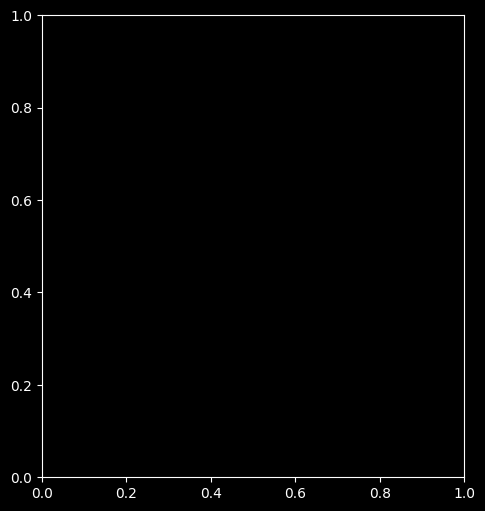

In [12]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

## EVALUATION

In [ ]:
test_data_gen = ImageDataGenerator(rescale=1.0/255)

test_data = test_data_gen.flow_from_directory(test_data_dir, target_size=image_size, class_mode='categorical',
                                             batch_size=32, shuffle=False)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
y_true = test_data.classes
y_pred = model.predict(test_data).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

fpr, tpr, _ = roc_curve(y_true, model.predict(test_data)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, model.predict(test_data)[:, 1])
average_precision = average_precision_score(y_true, model.predict(test_data)[:, 1])

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()

In [ ]:
class_report = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())
print(class_report)

FUCK. Everthing looks like rabbits.